# Santa Claus the Engineer!

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

## Question:

Suppose Santa is trying to speed up the already quick present-giving process on Christmas Eve. Instead of going to the roof of every building on Olin's campus, he decides to land on West Hall and launch all his presents to the tops of the other four buildings. He has a launcher that can launch presents at any velocity and angle that he desires (because Santa is an engineer).

At what angle and final velocity will optimize Santa's needed force to launch his presents to all the other campus buildings?

In [2]:
#define units

m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
feet = UNITS.feet
inch = UNITS.inch
degree = UNITS.degree;

Here are the heights of Olin's five buildings, according to the building plans. We decided to set the height of West Hall as our origin to provide clarity.

*Note: any variables pertaining to a building are assigned as "variable_building"*

In [3]:
height_WH = (53*feet + 1.625*inch).to(m) #16.196 m height of West Hall

height_EH = (67*feet).to(m) - height_WH #20.422 m height of East Hall
height_CC = (62*feet + 4* inch).to(m) - height_WH #18.992 m height of Campus Center
height_MH = (54*feet + 5.375*inch).to(m) - height_WH #15.596 m height of Milas Hall
height_AC =  (48*feet + 11.25*inch).to(m) - height_WH #14.916 m height of Academic Center

<Quantity(-1.2795249999999996, 'meter')>

... and the approximate distances between West Hall and the other four buildings (estimated using Google Maps).

In [4]:
to_EH = 80.88*m
to_CC = 72.69*m
to_AC = 141.29*m
to_MH = 108.69*m;

Now we need to create "params" and our System variable.  We'll start off by assuming Santa's launcher launches presents at a speed of 40m/s.

In [5]:
#create parameters
params = Params(x = 0 * m, 
                y = 0 * m,
                g = 9.81 * m/s**2,
                mass = 1.0206 * kg,
                height = 0.3048 * m,
                length = 0.3048 * m,
                width = 0.3048 * m,
                rho = 1.2 * kg/m**3,
                C_d = 0.8,
                angle = 45 * degree,
                velocity = 40 * m / s,
                t_end = 100 * s,
                d_end = 10*m)

,values
x,0 meter
y,0 meter
g,9.81 meter / second ** 2
mass,1.0206 kilogram
height,0.3048 meter
length,0.3048 meter
width,0.3048 meter
rho,1.2 kilogram / meter ** 3
C_d,0.8
angle,45 degree


Now, we'll write functions that will create the system object, calculate the force of drag on the present, compute the derivates of the state variables (like velocity and acceleration), and stop the simulation when the height of the present is 0.

In [6]:
#create our system object

def make_system(params):
    """Make a system object.
    
    params: Params object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(params)
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, velocity)
    
    # make the initial state
    init = State(x=x, y=y, vx=vx, vy=vy)
    
    # compute area from diameter
    area = height*length*height
    
    return System(params, init=init, area=area)

We also wrote drag and slope functions to update forces as the present moved through the air.

In [7]:
def drag_force(V, system):
    """Computes drag force in the opposite direction of `V`.
    
    V: velocity
    system: System object with rho, C_d, area
    
    returns: Vector drag force
    """
    unpack(system)
    mag = -rho * V.mag**2 * C_d * area / 2
    direction = V.hat()
    f_drag = mag * direction
    return f_drag

In [8]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)

    V = Vector(vx, vy)    
    a_drag = drag_force(V, system) / mass
    a_grav = Vector(0, -g)
    
    a = a_grav + a_drag
    
    return vx, vy, a.x, a.y

In [9]:
def event_func(state, t, system):
    """Stop when the y coordinate is 0.
    
    state: State object
    t: time
    system: System object
    
    returns: y coordinate
    """
    x, y, vx, vy = state
    return y+0.001

We then test the functions we've written by using *run_ode_solver*.

In [10]:
params = make_system(params)
results, details = run_ode_solver(params, slope_func, method="RK45", max_step=0.5*s, events = event_func)
details.message

'A termination event occurred.'

In [11]:
results.tail()

,x,y,vx,vy
2.392819,45.457752,22.754604,13.935293,-3.966550
2.892819,52.097686,19.677338,12.636463,-8.267918
3.392819,58.099844,14.565815,11.374198,-12.093849
3.892819,63.473472,7.672224,10.122883,-15.388633
4.352376,67.865602,-0.001000,8.997848,-17.927630


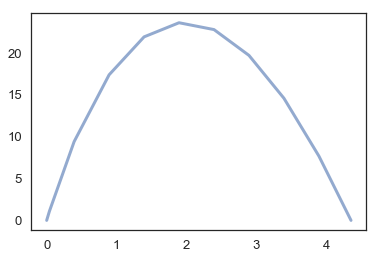

In [12]:
plot(results.y)

Now we know the functions written up to this point work. Our next step is to implement data we collected and figure out what the optimal speed and angle are for Santa if he launched presents from West Hall to the other four buildings on campus.

In [27]:
paramsEH = Params(params, h_end=height_EH, d_end=to_EH);
paramsMH = Params(params, h_end=height_MH, d_end=to_MH);
paramsAC = Params(params, h_end=height_AC, d_end=to_AC);
paramsCC = Params(params, h_end=height_CC, d_end=to_CC);

In [47]:
def event_func2(state, t, system):
    """Stop when the x coordinate is 0.
    
    state: State object
    t: time
    system: System object
    
    returns: x coordinate
    """
    unpack(system)
    x, y, vx, vy = state
    return x-d_end

def height_func(angle, params):  
    """Computes height for a given launch angle.
    
    angle: launch angle in degrees
    params: Params object
    
    returns: height in meters
    """
    params = Params(params, angle=angle)
    system = make_system(params)
    results, details = run_ode_solver(system, slope_func, events=event_func2)
    y_dist = get_last_value(results.y) * m
    return y_dist

In [40]:
opt_angle = 45*degree
def error_func(v, params):
    this_params = Params(params, velocity=v)
    optimal_height = max_bounded(height_func, [0,90], this_params)
    global opt_angle
    opt_angle = optimal_height.x*degree
    height = optimal_height.fun
    return height - params.h_end

In [41]:
res = fsolve(error_func, 45*m/s, paramsEH);
v_EH = res[0]*m/s
angle_EH = opt_angle
print(v_EH, angle_EH)

48.903586728999755 meter / second 38.5945570483135 degree


In [42]:
paramsEH = Params(paramsEH, velocity=v_EH, angle=angle_EH)
error_func(paramsEH.velocity, paramsEH)

<Quantity(-5.60440582830779e-13, 'meter')>

In [43]:
resultsEH, detailsEH = run_ode_solver(paramsEH, slope_func, method="RK45", max_step=0.5*s, events = event_func2)
detailsEH.message

'A termination event occurred.'

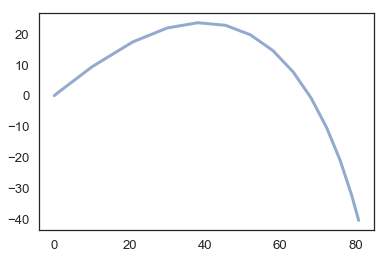

In [46]:
plot(resultsEH.x,resultsEH.y)

In [37]:
print(opt_angle)
res2 = fsolve(error_func, 45*m/s, paramsCC);
v_CC = res2[0]*m/s
angle_CC = opt_angle
print(v_CC, angle_CC)

35.99028565409101 degree
41.05387394593565 meter / second 37.15303030472443 degree


In [38]:
paramsCC = Params(paramsCC, velocity=v_CC, angle=angle_CC)
error_func(paramsCC.velocity, paramsCC)

<Quantity(3.97193389289896e-12, 'meter')>

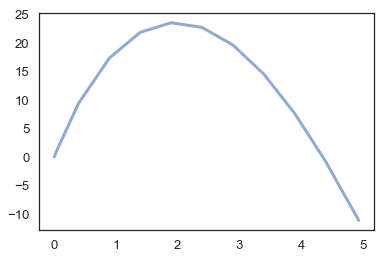

In [39]:
resultsCC, detailsCC = run_ode_solver(paramsCC, slope_func, method="RK45", max_step=0.5*s, events = event_func2)
detailsCC.message
plot(resultsCC.y)

In [23]:
print(opt_angle)
res3 = fsolve(error_func, 45*m/s, paramsMH);
v_MH = res3[0]*m/s
angle_MH = opt_angle
print(v_MH, angle_MH)

39.090930340504784 degree
68.39087073698052 meter / second 34.51096663527482 degree


In [28]:
paramsMH = Params(paramsMH, velocity=v_MH, angle=angle_MH)
error_func(paramsMH.velocity, paramsMH)

<Quantity(-2.4183921532028307e-09, 'meter')>

In [ ]:
print(opt_angle)
res4 = fsolve(error_func, 45*m/s, paramsAC);
v_AC = res4[0]*m/s
angle_AC = opt_angle
print(v_AC, angle_AC)

In [ ]:
paramsAC = Params(params, velocity=v_AC, angle=angle_AC)
error_func(paramsAC.velocity, paramsAC)

In [ ]:
def compute_force(velocity, angle, params):
    unpack(params)
    
    k_constant = (mass * velocity**2) / (1*m)
    force_to_push_spring = -k_constant * (1.0668*m) 
    return force_to_push_spring